In [3]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Kaggle's Cats vs Dogs**
Download our cats vs dogs dataset. Should talk around 15-20 seconds.
Source - https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:09<00:00, 92.7MB/s]


In [4]:
# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [5]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [7]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/dog.10156.jpg


#### **Create our transformations**

In [8]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

## **Create a Dataset class that stores our dataset information (paths, labels and transformations** 

This object can then be utilzied by torch functions such as `torch.utils.data.random_split`

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [9]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0 

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [10]:
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

### **Using our dataset Object**

In [11]:
# Getting a data entry
train.__getitem__(0)

(tensor([[[0.3294, 0.3294, 0.3294,  ..., 0.1765, 0.1765, 0.1686],
          [0.3294, 0.3333, 0.3373,  ..., 0.2392, 0.2235, 0.1922],
          [0.3490, 0.3451, 0.3451,  ..., 0.2863, 0.2824, 0.2902],
          ...,
          [0.5961, 0.6314, 0.6353,  ..., 0.4588, 0.4510, 0.4784],
          [0.6196, 0.6353, 0.6235,  ..., 0.4667, 0.4392, 0.4627],
          [0.6196, 0.6235, 0.6078,  ..., 0.4353, 0.4471, 0.4471]],
 
         [[0.2784, 0.2784, 0.2784,  ..., 0.2000, 0.2000, 0.1961],
          [0.2784, 0.2824, 0.2863,  ..., 0.2471, 0.2314, 0.2078],
          [0.2902, 0.2863, 0.2863,  ..., 0.2824, 0.2745, 0.2627],
          ...,
          [0.5098, 0.5059, 0.4902,  ..., 0.4706, 0.4549, 0.4667],
          [0.5294, 0.5255, 0.4902,  ..., 0.4667, 0.4353, 0.4549],
          [0.5255, 0.5294, 0.5059,  ..., 0.4314, 0.4431, 0.4471]],
 
         [[0.2118, 0.2118, 0.2118,  ..., 0.1255, 0.1255, 0.1294],
          [0.2118, 0.2157, 0.2196,  ..., 0.1608, 0.1451, 0.1294],
          [0.2235, 0.2235, 0.2235,  ...,

In [12]:
# Getting the shape of a single image
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


## **Using our dataset object to create our train, validation split**

In [13]:
train, val = torch.utils.data.random_split(train,[20000,5000]) 

In [14]:
# Getting a size of our
print(len(train))
print(len(val))

20000
5000


In [15]:
# Let's create an array of our labels
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


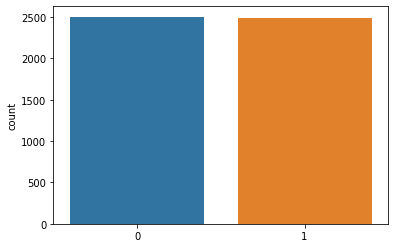

In [16]:
import seaborn as sns

sns.countplot(val_set_class_count)

## **Dataloaders - let's create our iterable over a dataset**

In [18]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

### **Use it to get some sample images**

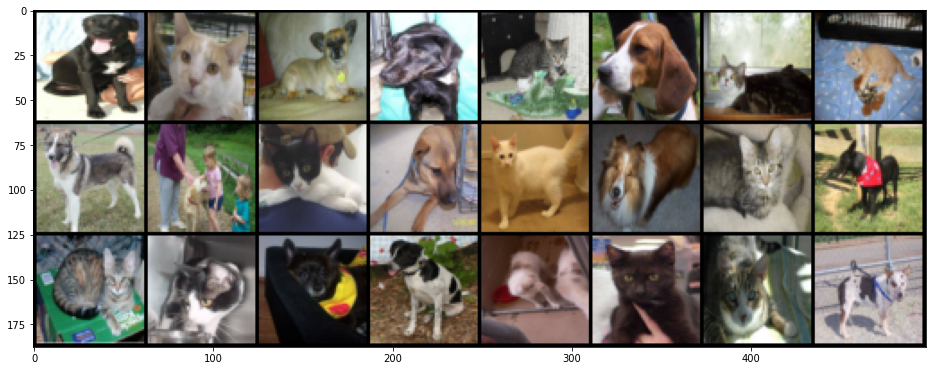

In [19]:
samples, labels = iter(train_dataset).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

**Now we build our Model**

We will use the ```nn.Sequential``` method to construct our model. Alernatively we can use the functional module, however this is simpler and more similar to styles you'll work with in Keras.

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            ) 
            
        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )
            
        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

### **Using TorchSummary to display a Keras style summary output**

`summary(your_model, input_size=(channels, H, W))`

In [21]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

### **Defining a Loss Function and Optimizer**

We need to define what type of loss we'll be using and what method will be using to update the gradients.
1. We use Cross Entropy Loss 
2. We use the Adam Optimization Descent Algorithm - we also specify a learn rate (LR) of 0.0005.
3. Set our epochs to 50

In [22]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

## **Train our Model**

**We use TQDM to perform a keras style training**


In [23]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes 
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step() 

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)    
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.58785
Epoch 1 Training Loss = 21.251812921142577
Epoch 1 Validation Accuracy = 0.6814
Epoch 1 Validation Loss = 19.270338869398568


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6979
Epoch 2 Training Loss = 18.974277114868165
Epoch 2 Validation Accuracy = 0.7346
Epoch 2 Validation Loss = 17.80214228903412


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.74655
Epoch 3 Training Loss = 17.591655561828613
Epoch 3 Validation Accuracy = 0.7544
Epoch 3 Validation Loss = 17.241740591207126


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.77035
Epoch 4 Training Loss = 16.91482945404053
Epoch 4 Validation Accuracy = 0.775
Epoch 4 Validation Loss = 16.70434340701741


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7925
Epoch 5 Training Loss = 16.34585187225342
Epoch 5 Validation Accuracy = 0.777
Epoch 5 Validation Loss = 16.647071285612263


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.80435
Epoch 6 Training Loss = 15.990167916870117
Epoch 6 Validation Accuracy = 0.8006
Epoch 6 Validation Loss = 16.037068175662096


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.819
Epoch 7 Training Loss = 15.584844674682618
Epoch 7 Validation Accuracy = 0.7992
Epoch 7 Validation Loss = 16.032908743354167


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.82835
Epoch 8 Training Loss = 15.272838342285157
Epoch 8 Validation Accuracy = 0.8082
Epoch 8 Validation Loss = 15.916514320737997


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.83945
Epoch 9 Training Loss = 14.952771607971192
Epoch 9 Validation Accuracy = 0.807
Epoch 9 Validation Loss = 15.799786339899537


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.84895
Epoch 10 Training Loss = 14.672428895568848
Epoch 10 Validation Accuracy = 0.8114
Epoch 10 Validation Loss = 15.718038325097151


In [ ]:
train_loss

[14.5841179977417,
 14.335508157348633,
 14.02681951599121,
 13.766978019714356,
 13.579335682678222,
 13.306206069946288,
 13.100996505737305,
 12.924030900573731,
 12.707768827819825,
 12.692664804077149]

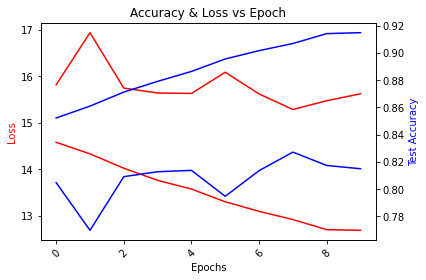

In [ ]:
epoch_log = [*range(epochs)]

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuarcy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [ ]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

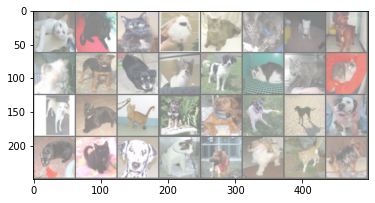

GroundTruth:  00000011011010001001111100101101


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Loading one mini-batch
dataiter = iter(val_dataset)
images, labels = dataiter.next()

# Display images using torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s' % labels[j].numpy() for j in range(32)))

In [ ]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
model = CNN()
model.to(device)

# Load weights from the specified path
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

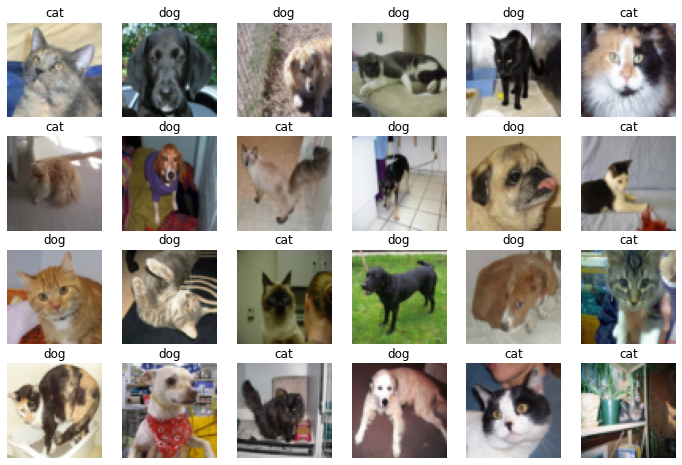

In [ ]:
samples, _ = iter(val_dataset).next()
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))